Write the stochastic simulation algorithm (SSA) for the simple gene expression model G-> G*, G* -> G, G -> G + M, M -> 0, M -> M + P where G is active gene, G* is inactive gene, M is mRNA and P is protein.  Each time you run this it simulates a different cell. Run the simulation to a certain time for 1000 cells, calculate the mean of mRNA and protein and their variance. Is the variance smaller or larger than the mean?
```
	1. Initialisation:
	- Set the initial state N for N_G, N_G*, N_M, and N_P (number of molecules of G, G*, M, P)
	- Initialise time t=0
	2. Reaction Propensities:
	- Define the reaction propensities a1, a2, a3, a4 and a5 for the reactions based on their rates and the current state.
		○ a1= rate of G--> G*
		○ a2 = rate of G* --> G
		○ a3 = rate of G --> G+M
		○ a4 = rate of M --> M
		○ a5 = rate of M --> M + P 
		○ a6 = rate of P --> 
		○ a0 = a1 + a2 + a3 + a4 + a5 +a6
	3. Reaction Selection: 
	- Draw a random number r1 from a uniform distribution between 0 and 1
	- Select the reaction R (the next reaction to occur) based on r1 falling into one of these intervals:
		○ If 0 <= r1 < a1/a0, reaction 1 occurs
		○ If a1/a0 <= r1 < (a1+a2)/a0, reaction 2 occurs
		○ If (a1+a2)/a0 <= r1 < (a1+a2+a3)/a0, reaction 3 occurs
		○ If (a1+a2+a3)/a0 <= r1 < (a1+a2+a3+a4)/a0, reaction 4 occurs
		○ If (a1+a2+a3+a4) <= r1 < (a1+a2+a3+a4+a5)/a0, reaction 5 occurs 
		○ If (a1+a2+a3+a4+a5) <= r1 < 1, reaction 6 occurs 
	4. Time Step:
	- Draw a sample τ from the random variable T (the time to the next reaction)
	-  τ = -1/a0 ln(r1), where r1 is a random number taken from a uniformly distribution between 0 and 1. 
	5. State Update:
	- Increment the simulation time t --> t + τ to account for the elapsed time
	- Update the state vector N --> N + s_k to reflect the fact that reaction R has occurred
Repeat steps 2-5 until max simulation time is reached.
```

In [1]:
import matplotlib.pyplot as plt
import multiprocessing
import tqdm
import numpy as np
import scipy.stats as st
import numba
import biocircuits

# We only want steady state data... To do this, we can choose the last 20% of the simulated data.

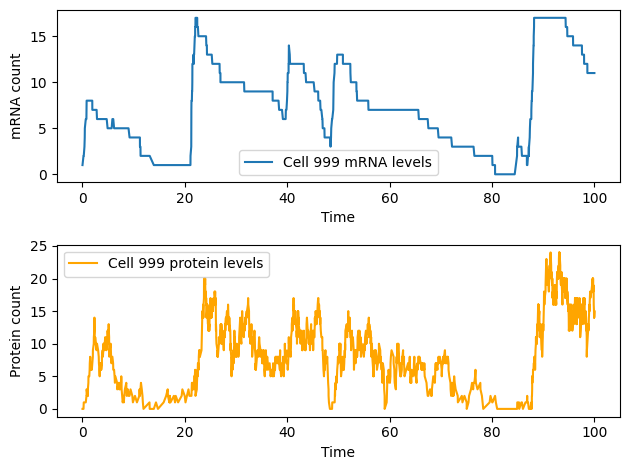

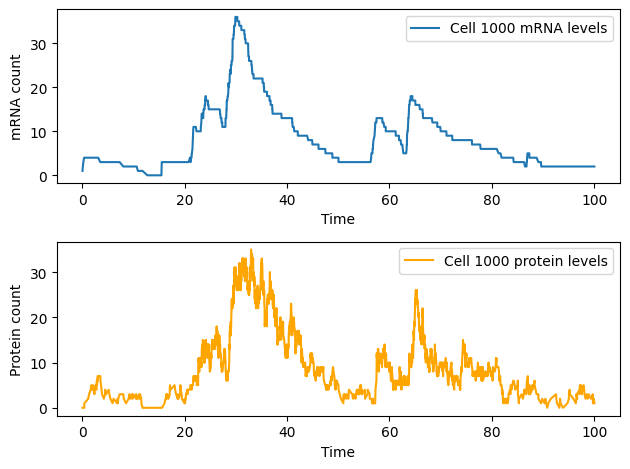

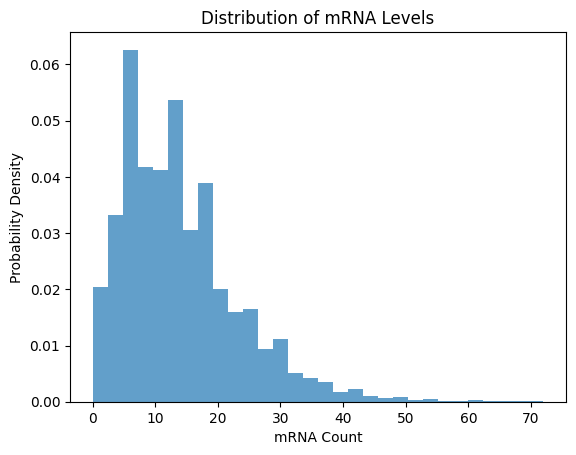

Mean mRNA: 13.89, Variance mRNA: 88.48, FF: 6.37, Expected FF: 11.00
Mean Protein: 14.50, Variance Protein: 101.93
Covariance between mRNA and Protein: 85.01


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the rates for each reaction (constants)
alpha_on = 0.1     # Rate of G* -> G
alpha_off = 1     # Rate of G -> G*
beta = 10          # Rate of G -> G + M (mRNA production)
gamma_m = 0.1      # Rate of M -> 0 (mRNA degradation)
gamma_p = 1      # Rate of M -> M + P (protein production)
protein_degradation = 1  # Rate of P -> 0 (protein degradation)

# Simulation time and number of cells
T = 100             # Simulation time
num_cells = 1000    # Number of cells to simulate

def gillespie_algorithm():
    # 1. Initialisation: Initial states - G is active, M = 0, P = 0
    G_active = 1    # G is initially active
    M = 0           # Initial mRNA count
    P = 0           # Initial protein count
    t = 0           # Initialize time

    # Time until we stop the simulation
    t_max = T

    # Lists to store mRNA and protein levels
    mRNA_levels = []
    protein_levels = []
    times = []

    # Run the simulation until t exceeds t_max
    while t < t_max:
        # 2. Calculate reaction propensities (reaction rates)
        a1 = alpha_off * G_active         # Propensity for G -> G*
        a2 = alpha_on * (1 - G_active)  # Propensity for G* -> G
        a3 = beta * G_active             # Propensity for G -> G + M (mRNA production)
        a4 = gamma_m * M                 # Propensity for M -> 0 (mRNA degradation)
        a5 = gamma_p * M                 # Propensity for M -> M + P (protein production)
        a6 = protein_degradation * P     # Propensity for P -> 0 (protein degradation)

        # Total propensity
        a0 = a1 + a2 + a3 + a4 + a5 + a6

        # If no reactions can happen, stop
        if a0 == 0:
            break

        # 3. Sample which reaction happens
        # r = np.random.uniform(0, a0)
        r1 = np.random.random()
        r2 = np.random.random() * a0  # Scale r2 to the range [0, a0)

        # Determine which reaction occurs
        thresholds = np.cumsum([a1, a2, a3, a4, a5, a6])  # Cumulative sum of propensities
        reaction_index = np.searchsorted(thresholds, r2)  # Find which interval r2 falls into

        if reaction_index == 0:
            G_active = 0  # G -> G*
        elif reaction_index == 1:
            G_active = 1  # G* -> G
        elif reaction_index == 2:
            M += 1        # G -> G + M (mRNA production)
        elif reaction_index == 3:
            M = max(0, M - 1)  # M -> 0 (mRNA degradation)
        elif reaction_index == 4:
            P += 1        # M -> M + P (protein production)
        elif reaction_index == 5:
            P = max(0, P - 1)  # P -> 0 (protein degradation)

        # 4. Sample time until next reaction
        # tau = np.random.exponential(1 / a0)
        tau = -np.log(r1) / a0

        # 5.1 Update the time
        t += tau

        # 5.2 Store the current mRNA and protein levels
        mRNA_levels.append(M)
        protein_levels.append(P)
        times.append(t)

    # Return time series data
    return times, mRNA_levels, protein_levels

def gillespie_algorithm():
    # Initialize state
    G_active = 1
    M = 0
    P = 0
    t = 0
    t_max = T

    # Stoichiometry matrix
    S = np.array([
        [-1,  0,  0],  # G -> G*
        [1,   0,  0],  # G* -> G
        [0,   1,  0],  # G -> G + M
        [0,  -1,  0],  # M -> 0
        [0,   0,  1],  # M -> M + P
        [0,   0, -1]   # P -> 0
    ])

    # Time series storage
    mRNA_levels = []
    protein_levels = []
    times = []

    while t < t_max:
        # Calculate propensities
        propensities = np.array([
            alpha_off * G_active,            # G -> G*
            alpha_on * (1 - G_active),       # G* -> G
            beta * G_active,                 # G -> G + M
            gamma_m * M,                     # M -> 0
            gamma_p * M,                     # M -> M + P
            protein_degradation * P          # P -> 0
        ])
        a0 = propensities.sum()

        # Stop if no reactions can occur
        if a0 == 0:
            break

        # Sample time to next reaction, to avoid floating-point issues
        tau = -np.log(np.random.uniform(0, 1)) / a0
        t += tau

        # Sample which reaction occurs, rather than using cumulative probabilities
        reaction_index = np.random.choice(len(propensities), p=propensities / a0)

        # Update state based on stoichiometry
        if reaction_index == 0:
            G_active = 0  # G -> G*
        elif reaction_index == 1:
            G_active = 1  # G* -> G
        else:
            update = S[reaction_index]
            M = max(0, M + update[1])  # Prevent negative M
            P = max(0, P + update[2])  # Prevent negative P

        # Record the system state
        mRNA_levels.append(M)
        protein_levels.append(P)
        times.append(t)

    return times, mRNA_levels, protein_levels


def check_steady_state(time_series, window_size=50, tolerance=0.01):
    """
    Checks if the time series has reached steady-state.
    - time_series: Array of molecule counts (e.g., mRNA or protein).
    - window_size: Number of time points for calculating the moving average.
    - tolerance: Tolerance for steady-state fluctuation.
    Returns True if steady-state is reached, False otherwise.
    """
    moving_avg = np.convolve(time_series, np.ones(window_size)/window_size, mode='valid')
    return np.all(np.abs(np.diff(moving_avg)) < tolerance)

# Arrays to store final mRNA and protein levels for all cells after steady-state is reached
mRNA_final_levels = []
protein_final_levels = []

# Simulate the process for num_cells cells and check for steady-state
for i,_ in enumerate(range(num_cells)):
    times, mRNA_levels, protein_levels = gillespie_algorithm()
    
    # Check for steady state using moving average on the time series
    # if check_steady_state(mRNA_levels) and check_steady_state(protein_levels):
    
    steady_state_mRNA = mRNA_levels[-int(0.2 * len(mRNA_levels)):]
    steady_state_protein = protein_levels[-int(0.2 * len(protein_levels)):]

    # steady_state_mRNA = mRNA_levels
    # steady_state_protein = protein_levels
    
    mRNA_final_levels.extend(steady_state_mRNA)
    protein_final_levels.extend(steady_state_protein)

    # Plot mRNA and protein levels for the last 5 cells
    if i >= num_cells - 2:
        plt.subplot(2, 1, 1)
        plt.plot(times, mRNA_levels, label=f'Cell {i+1} mRNA levels')
        plt.xlabel('Time')
        plt.ylabel('mRNA count')
        plt.legend()

        # Plot protein levels
        plt.subplot(2, 1, 2)
        plt.plot(times, protein_levels, label=f'Cell {i+1} protein levels', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Protein count')
        plt.legend()

        plt.tight_layout()
        plt.show()
    #     print("Steady state not reached for this cell.")

# Convert results to numpy arrays
mRNA_final_levels = np.array(mRNA_final_levels)
protein_final_levels = np.array(protein_final_levels)

plt.hist(mRNA_final_levels, bins=30, density=True, alpha=0.7, label='Simulated')
plt.title("Distribution of mRNA Levels")
plt.xlabel("mRNA Count")
plt.ylabel("Probability Density")
plt.show()

# Calculate mean and variance for mRNA and protein levels
mean_mRNA = np.mean(mRNA_final_levels)
variance_mRNA = np.var(mRNA_final_levels)
FF=variance_mRNA/mean_mRNA
FF_expected = 1 + beta/alpha_off

mean_protein = np.mean(protein_final_levels)
variance_protein = np.var(protein_final_levels)
covariance = np.cov(mRNA_final_levels, protein_final_levels)[0, 1]

print(f"Mean mRNA: {mean_mRNA:.2f}, Variance mRNA: {variance_mRNA:.2f}, FF: {FF:.2f}, Expected FF: {FF_expected:.2f}")
# assert np.isclose(FF, 1 + beta/alpha_off, atol=0.1), "FF mismatch!"

print(f"Mean Protein: {mean_protein:.2f}, Variance Protein: {variance_protein:.2f}")
print(f"Covariance between mRNA and Protein: {covariance:.2f}")

# plotting the mean mRNA and protein levels over time
# plt.figure()
# plt.plot(times, np.mean(mRNA_final_levels), label='mRNA levels')
# plt.plot(times, np.mean(protein_final_levels), label='Protein levels')
# plt.xlabel('Time')
# plt.ylabel('Molecule count')
# plt.legend()
# plt.show()

# Caltech codes
Defining the functions for running Gillespie algorithm

In [14]:
# Define the update matrix for the reactions
# Columns: G, G*, M, P
update_matrix = np.array([
    [-1, 1, 0, 0],   # G -> G* (Gene activation)
    [1, -1, 0, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1, 0],    # G -> G + M (mRNA production)
    [0, 0, -1, 0],   # M -> 0 (mRNA degradation)
    [0, 0, 0, 1],    # M -> M + P (protein production)
    [0, 0, 0, -1]    # P -> 0 (protein degradation)
], dtype=int)

def circuit_propensity(propensities, population, t, alpha_off, alpha_on, beta, gamma_m, gamma_p, protein_degradation):
    """
    Updates the propensities for the circuit reactions based on defined rates.

    Parameters:
        propensities: Array of propensities
        population: Array of species populations [G, G*, M, P]
        t: Time (not used but required by signature)
        alpha_off: Rate of G -> G*
        alpha_on: Rate of G* -> G
        beta: Rate of G -> G + M (mRNA production)
        gamma_m: Rate of M -> 0 (mRNA degradation)
        gamma_p: Rate of M -> M + P (protein production)
        protein_degradation: Rate of P -> 0 (protein degradation)
    """
    # Unpack population
    G, G_star, M, P = population
    
    # Update propensities for each reaction
    propensities[0] = alpha_off * G         # G -> G*
    propensities[1] = alpha_on * G_star     # G* -> G
    propensities[2] = beta * G              # G -> G + M
    propensities[3] = gamma_m * M           # M -> 0
    propensities[4] = gamma_p * M           # M -> M + P
    propensities[5] = protein_degradation * P  # P -> 0

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

Running the simulation to check whether the observed Fano factors match with the theoretical Fano factor
- Observed Fano Factor = variance of mRNA / mean of mRNA
- Theoretical Fano Factor = 1 + (mRNA production rate / rate of gene switching off)

Under the following conditions: 
1. Set alpha_off >> alpha_on
2. Set beta >> alpha_off
3. Reaction sampled at Steady State, and t_ss >> 10 / gamma_m

100%|██████████| 1000/1000 [00:47<00:00, 21.19it/s]


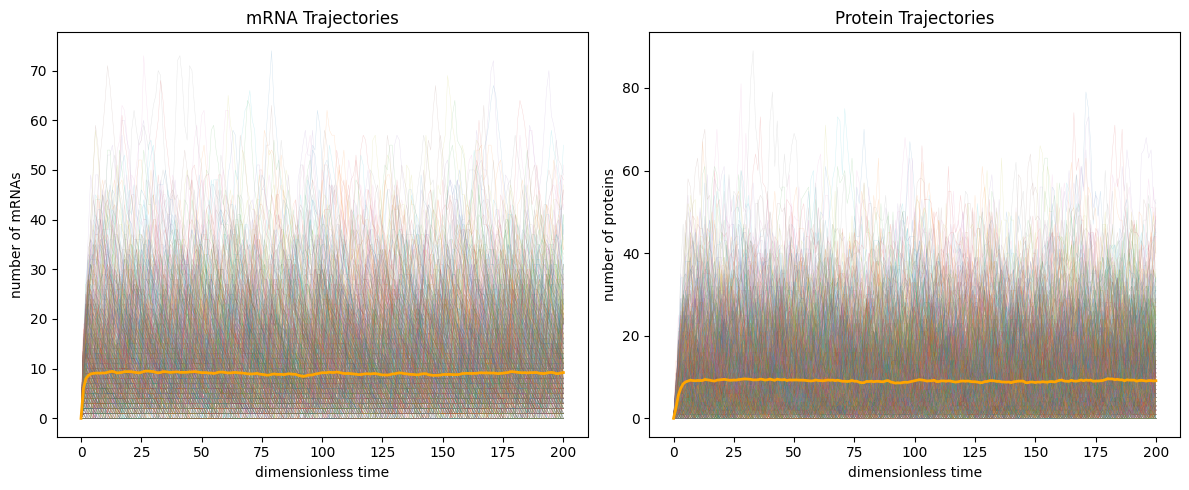

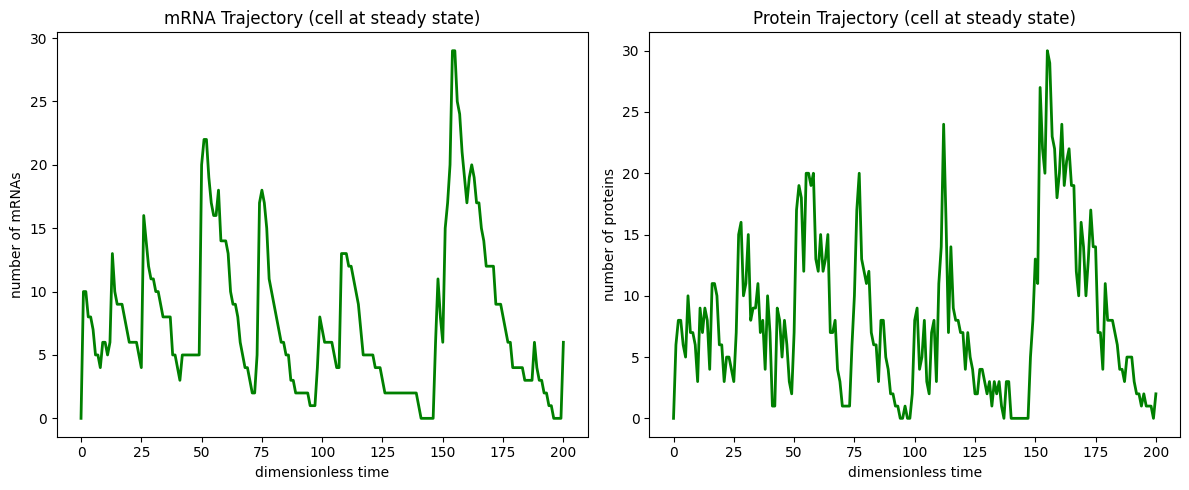

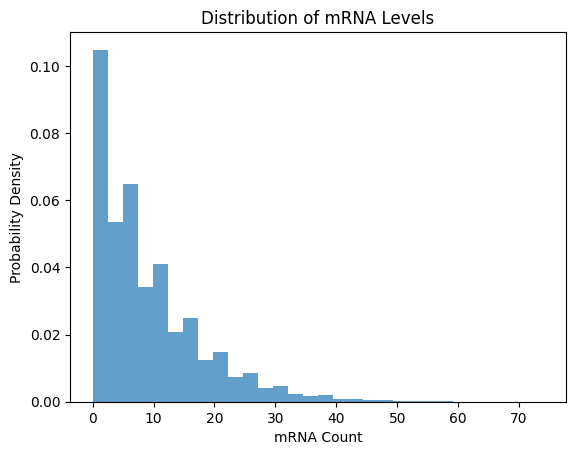

mRNA mean copy number = 8.996701492537314
Protein mean copy number = 8.973144278606965

mRNA variance = 76.81463091089327
Protein variance = 81.8118857354026
Fano factor for mRNA: 8.54
Expected Fano factor for mRNA: 11.00


/tmp/ipykernel_1426596/3278267136.py:89: RuntimeWarning: invalid value encountered in divide
  fano_m = samples[:,:,2].var(axis=0) / samples[:,:,2].mean(axis=0)


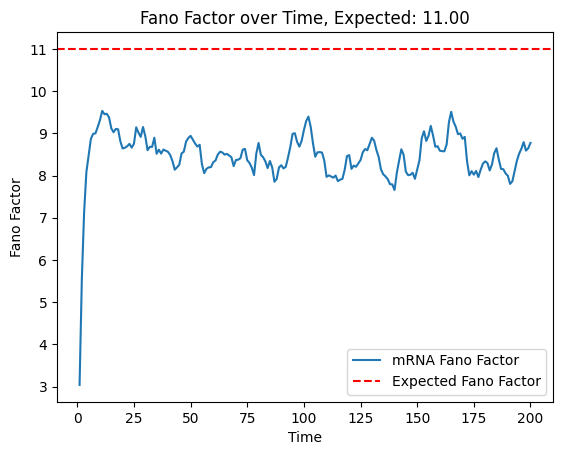

In [61]:
# Define the rates for each reaction (constants)
# To have matching theoretical and actual Fano factors, we need to: 
# 1. Set alpha_off >> alpha_on
# 2. Set beta >> alpha_off
# 3. Reaction sampled at Steady State, and t_ss >> 10 / gamma_m

alpha_off = 1            # Rate of G -> G*
alpha_on = 0.1           # Rate of G* -> G
beta = 10                # Rate of G -> G + M (mRNA production)
gamma_m = 0.1            # Rate of M -> 0 (mRNA degradation)
gamma_p = 1              # Rate of M -> M + P (protein production)
protein_degradation = 1  # Rate of P -> 0 (protein degradation)

# Set simulation parameters
params = (alpha_off, alpha_on, beta, gamma_m, gamma_p, protein_degradation)
time_points = np.linspace(0, 200, 201)      # Time range
# make sure we have t_ss >> 10 / gamma_m
if len(time_points) < 10/gamma_m:
    time_points = np.linspace(0, 10/gamma_m, 10/gamma_m+1)

population_0 = np.array([1, 0, 0, 0], dtype=int)  # Initial [G, G*, M, P]
size = 1000  # Number of stochastic simulations

# Seed random number generator for reproducibility
np.random.seed(42)

# Run Gillespie simulations
samples = np.empty((size, len(time_points), 4), dtype=int)
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespie_ssa(circuit_propensity, update_matrix, population_0, time_points, args=params)

# Plot trajectories and mean using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot mRNA trajectories
for x in samples[:, :, 2]:
    axs[0].plot(time_points, x, linewidth=0.3, alpha=0.2)
axs[0].plot(time_points, samples[:, :, 2].mean(axis=0), linewidth=2, color='orange')
axs[0].set_xlabel('dimensionless time')
axs[0].set_ylabel('number of mRNAs')
axs[0].set_title('mRNA Trajectories')

# Plot protein trajectories
for x in samples[:, :, 3]:
    axs[1].plot(time_points, x, linewidth=0.3, alpha=0.2)
axs[1].plot(time_points, samples[:, :, 3].mean(axis=0), linewidth=2, color='orange')
axs[1].set_xlabel('dimensionless time')
axs[1].set_ylabel('number of proteins')
axs[1].set_title('Protein Trajectories')

plt.tight_layout()
plt.show()

# plot ONE mRNA and protein trajectory
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(time_points, samples[-50, :, 2], linewidth=2, color='green')
axs[0].set_xlabel('dimensionless time')
axs[0].set_ylabel('number of mRNAs')
axs[0].set_title('mRNA Trajectory (cell at steady state)')

axs[1].plot(time_points, samples[-50, :, 3], linewidth=2, color='green')
axs[1].set_xlabel('dimensionless time')
axs[1].set_ylabel('number of proteins')
axs[1].set_title('Protein Trajectory (cell at steady state)')

plt.tight_layout()
plt.show()

# plot the mRNA level distribution
plt.hist(samples[:,:,2].flatten(), bins=30, density=True, alpha=0.7, label='Simulated')
plt.title("Distribution of mRNA Levels")
plt.xlabel("mRNA Count")
plt.ylabel("Probability Density")
plt.show()

# Output mean values and noise
print("mRNA mean copy number =", samples[:, :, 2].mean())
print("\nmRNA variance =", samples[:, :, 2].std()**2)
# print("Protein mean copy number =", samples[:, :, 3].mean())
# print("Protein variance =", samples[:, :, 3].std()**2)

# # calculate fano factor
fano_m = samples[:,:,2].var() / samples[:,:,2].mean()
print(f'Fano factor for mRNA: {fano_m:.2f}')
expected_fano_m = 1 + beta / alpha_off
print(f'Expected Fano factor for mRNA: {expected_fano_m:.2f}')

# plot the Fano factor over time
fano_m = samples[:,:,2].var(axis=0) / samples[:,:,2].mean(axis=0)
plt.plot(time_points, fano_m, label='mRNA Fano Factor')
plt.axhline(expected_fano_m, color='red', linestyle='--', label='Expected Fano Factor')
plt.xlabel('Time')  
plt.ylabel('Fano Factor')
plt.legend()
plt.title(f'Fano Factor over Time, Expected: {expected_fano_m:.2f}')
plt.show()

Fano factor for mRNA: 1.09
Expected Fano factor for mRNA: 4.00


/tmp/ipykernel_1426596/2354626184.py:8: RuntimeWarning: invalid value encountered in divide
  fano_m = samples[:,:,2].var(axis=0) / samples[:,:,2].mean(axis=0)


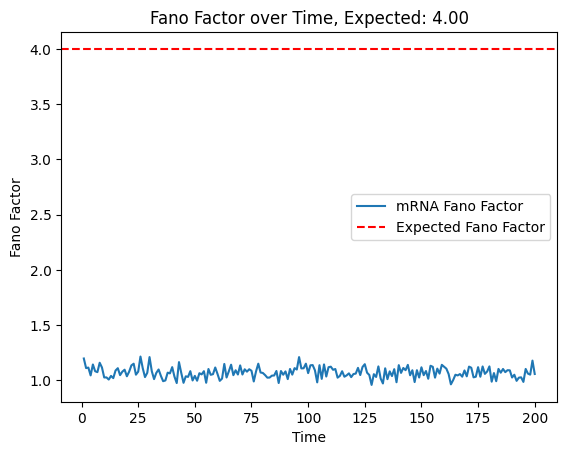

In [42]:
# # calculate fano factor
fano_m = samples[:,:,2].var() / samples[:,:,2].mean()
print(f'Fano factor for mRNA: {fano_m:.2f}')
expected_fano_m = 1 + beta / alpha_off
print(f'Expected Fano factor for mRNA: {expected_fano_m:.2f}')

# plot the Fano factor over time
fano_m = samples[:,:,2].var(axis=0) / samples[:,:,2].mean(axis=0)
plt.plot(time_points, fano_m, label='mRNA Fano Factor')
plt.axhline(expected_fano_m, color='red', linestyle='--', label='Expected Fano Factor')
plt.xlabel('Time')  
plt.ylabel('Fano Factor')
plt.legend()
plt.title(f'Fano Factor over Time, Expected: {expected_fano_m:.2f}')
plt.show()

## Finetuning the parameters to find the most suitable ones for matching FF values

In [63]:
# define a list of parameters for running simulations, but we need to make sure beta >> alpha_off >> alpha_on
alpha_off = [0.1, 1, 10, 100, 200]
alpha_on = [0.01, 0.1, 1, 10, 100]
beta = [1, 10, 100, 200, 500]
gamma_m = [0.01, 0.1, 1, 10, 100]
gamma_p = [0.01, 0.1, 1, 10, 100]
protein_degradation = [1,10] 

# run the simulation for all the parameters
results = []
for a_off in tqdm.tqdm(alpha_off, desc="alpha_off"):
    for a_on in tqdm.tqdm(alpha_on, desc="alpha_on", leave=False):
        for b in tqdm.tqdm(beta, desc="beta", leave=False):
            for g_m in tqdm.tqdm(gamma_m, desc="gamma_m", leave=False):
                for g_p in tqdm.tqdm(gamma_p, desc="gamma_p", leave=False):
                    for p_d in tqdm.tqdm(protein_degradation, desc="protein_degradation", leave=False):
                        params = (a_off, a_on, b, g_m, g_p, p_d)
                        samples = np.empty((size, len(time_points), 4), dtype=int)
                        for i in range(size):
                            samples[i, :, :] = gillespie_ssa(circuit_propensity, update_matrix, population_0, time_points, args=params)
                        fano_m = samples[:,:,2].var() / samples[:,:,2].mean()
                        expected_fano_m = 1 + b / a_off
                        results.append([a_off, a_on, b, g_m, g_p, p_d, fano_m, expected_fano_m])

alpha_off:   0%|          | 0/5 [00:00<?, ?it/s]












































































alpha_off:   0%|          | 0/5 [08:47<?, ?it/s]


KeyboardInterrupt: 

The entire code block, with multiprocessing, designed for running on HPCs. 

In [15]:
import matplotlib.pyplot as plt
import multiprocessing
import tqdm
import numpy as np
import os
import scipy.stats as st
import numba
import biocircuits
import itertools


# Define the update matrix for the reactions
# Columns: G, G*, M, P
update_matrix = np.array([
    [-1, 1, 0, 0],   # G -> G* (Gene activation)
    [1, -1, 0, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1, 0],    # G -> G + M (mRNA production)
    [0, 0, -1, 0],   # M -> 0 (mRNA degradation)
    [0, 0, 0, 1],    # M -> M + P (protein production)
    [0, 0, 0, -1]    # P -> 0 (protein degradation)
], dtype=int)

def circuit_propensity(propensities, population, t, alpha_off, alpha_on, beta, gamma_m, gamma_p, protein_degradation):
    """
    Updates the propensities for the circuit reactions based on defined rates.

    Parameters:
        propensities: Array of propensities
        population: Array of species populations [G, G*, M, P]
        t: Time (not used but required by signature)
        alpha_off: Rate of G -> G*
        alpha_on: Rate of G* -> G
        beta: Rate of G -> G + M (mRNA production)
        gamma_m: Rate of M -> 0 (mRNA degradation)
        gamma_p: Rate of M -> M + P (protein production)
        protein_degradation: Rate of P -> 0 (protein degradation)
    """
    # Unpack population
    G, G_star, M, P = population
    
    # Update propensities for each reaction
    propensities[0] = alpha_off * G         # G -> G*
    propensities[1] = alpha_on * G_star     # G* -> G
    propensities[2] = beta * G              # G -> G + M
    propensities[3] = gamma_m * M           # M -> 0
    propensities[4] = gamma_p * M           # M -> M + P
    propensities[5] = protein_degradation * P  # P -> 0

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

# Worker function for running simulations
def run_simulation(params):
    a_off, a_on, b, g_m, g_p, p_d = params
    time_points = np.linspace(0, 200, 201)

    # Ensure steady-state condition t_ss >> 10 / gamma_m
    if len(time_points) < int(10 / g_m):
        time_points = np.linspace(0, int(10 / g_m), int(10 / g_m + 1))

    population_0 = np.array([1, 0, 0, 0], dtype=int)  # Initial [G, G*, M, P]
    samples = np.empty((size, len(time_points), 4), dtype=int)

    for i in range(size):
        samples[i, :, :] = gillespie_ssa(circuit_propensity, update_matrix, population_0, time_points, args=(a_off, a_on, b, g_m, g_p, p_d))
    
    # Compute Fano factor
    fano_m = samples[:, :, 2].var() / samples[:, :, 2].mean()
    expected_fano_m = 1 + b / a_off

    # Save samples to a file
    sample_file = f"samples_{a_off}_{a_on}_{b}_{g_m}_{g_p}_{p_d}.npy"
    np.save(sample_file, samples)

    return [a_off, a_on, b, g_m, g_p, p_d, fano_m, expected_fano_m]

# Define the rates for each reaction (constants)
# To have matching theoretical and actual Fano factors, we need to: 
# 1. Set alpha_off >> alpha_on
# 2. Set beta >> alpha_off
# 3. Reaction sampled at Steady State, and t_ss >> 10 / gamma_m

# define a list of parameters for running simulations, but we need to make sure beta >> alpha_off >> alpha_on
# alpha_off = np.logspace(-1, 2.3, 10)  # 0.1 to ~200, logarithmic
# alpha_on = np.logspace(-2, 2, 10)    # 0.01 to 100, logarithmic
# beta = np.linspace(1, 500, 10)       # 1 to 500, linear
# gamma_m = np.logspace(-2, 2, 5)     # 0.01 to 100, logarithmic
# gamma_p = np.logspace(-2, 2, 5)     # 0.01 to 100, logarithmic
# protein_degradation = np.linspace(1, 10, 5)  # 1 to 10, linear

# to test whether the multiprocessing function works as expected, let's run 2 single simulations
alpha_off = [0.1, 1]
alpha_on = [0.01, 0.1]
beta = [1, 10]
gamma_m = [0.01]
gamma_p = [0.01, 0.1]
protein_degradation = [1] 

size = 100  # Number of simulations
# Generate parameter grid with filtering conditions to enforce beta >> alpha_off >> alpha_on
filtered_param_grid = [
    (a_off, a_on, b, g_m, g_p, p_d)
    for a_off, a_on, b, g_m, g_p, p_d in itertools.product(alpha_off, alpha_on, beta, gamma_m, gamma_p, protein_degradation)
    if b > 10 * a_off > 10 * a_on  # Enforce beta >> alpha_off >> alpha_on
]

# CSV File Path
output_file = "SSA_finetune_results.csv"

# Write header only if file doesn't exist
if not os.path.exists(output_file):
    with open(output_file, "w") as f:
        f.write("alpha_off,alpha_on,beta,gamma_m,gamma_p,protein_degradation,fano_m,expected_fano_m\n")

if __name__ == "__main__":
    with multiprocessing.Pool(processes=12) as pool: # automatically uses all CPU cores, use multiprocessing.Pool(processes=num_cores_to_use) to modify the number of cores
        with tqdm.tqdm(total=len(filtered_param_grid), desc='Overall Progress', position=0, dynamic_ncols=True) as pbar:
            for result in pool.imap_unordered(run_simulation, filtered_param_grid):

                # unpack the results
                a_off, a_on, b, g_m, g_p, p_d, *_ = result
                # update progress bar description
                pbar.set_description(f"a_off={a_off:.2f}, a_on={a_on:.2f}, b={b:.2f}, g_m={g_m:.2f}, g_p={g_p:.2f}, p_d={p_d:.2f}")

                # save results after each iteration
                with open(output_file, "a") as f:
                    f.write(",".join(map(str, result)) + "\n")

                # progress bar increment by 1
                pbar.update(1)

a_off=0.10, a_on=0.01, b=10.00, g_m=0.01, g_p=0.10, p_d=1.00: 100%|██████████| 2/2 [00:27<00:00, 14.00s/it]


In [10]:
# read the sample file 
sample_file = "./samples_0.1_0.01_10_0.01_0.1_1.npy"
samples = np.load(sample_file)
print(samples.shape)
samples

(1000, 1001, 4)


# Modified Gillespie SSA Code for TF Translocation
**Key Additions:**

**1. Species:** Add transcription factors (TFs) and distinguish between their nuclear (TF_nuc) and cytoplasmic (TF_cyt) states.

**2. Reactions:**
- Cytoplasmic TF → Nuclear TF (TF translocation).
- Nuclear TF → Cytoplasmic TF (TF export).
- TF in the nucleus activates mRNA transcription. *(NOT YET IMPLEMENTED)*

**3. Propensity Updates:** Include rates for translocation and transcription activation.

**4. Update Matrix:** Adjust the update matrix for new species and reactions.

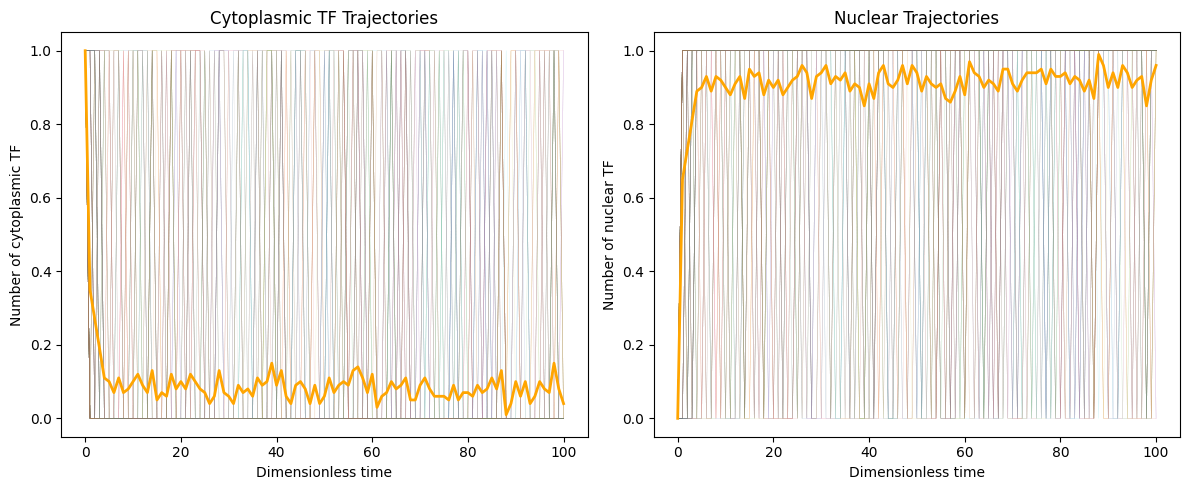

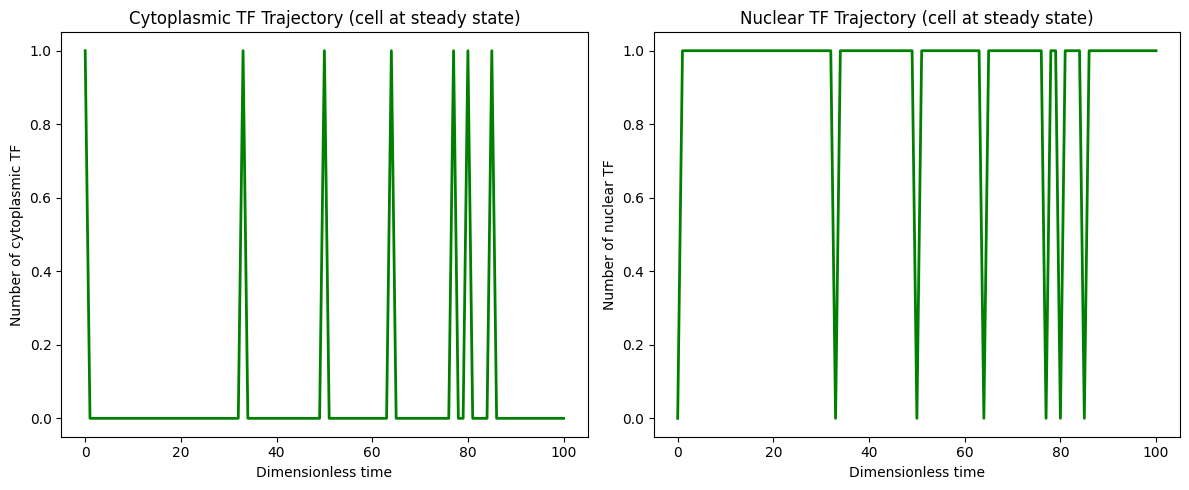

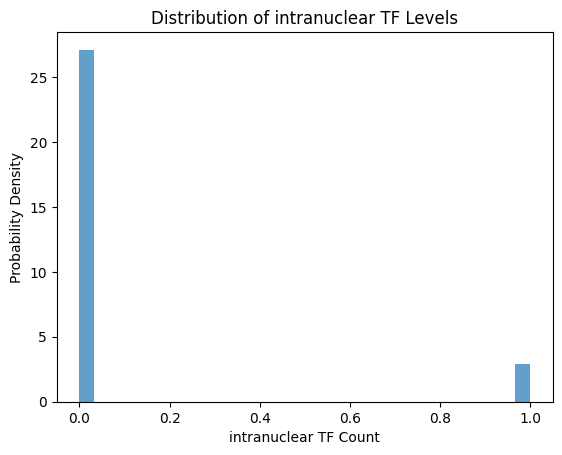

Nuclear TF mean = 0.9198
Cytoplasmic TF mean = 0.0802
mRNA mean = 90.0828
Fano factor for mRNA: 1.91
Expected Fano factor for mRNA: 11.00


In [12]:
# Updated update matrix: columns = [G, G*, M, P, TF_cyt, TF_nuc]
update_matrix = np.array([
    [-1, 1, 0, 0, 0, 0],   # G -> G* (Gene activation)
    [1, -1, 0, 0, 0, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1, 0, 0, 0],    # G* -> G* + M (mRNA production)
    [0, 0, -1, 0, 0, 0],   # M -> 0 (mRNA degradation)
    [0, 0, 0, 1, 0, 0],    # M -> M + P (protein production)
    [0, 0, 0, -1, 0, 0],   # P -> 0 (protein degradation)
    [0, 0, 0, 0, -1, 1],   # TF_cyt -> TF_nuc (translocation to nucleus)
    [0, 0, 0, 0, 1, -1]    # TF_nuc -> TF_cyt (export back to cytoplasm)
], dtype=int)

def tf_translocation_propensity(propensities, population, t, alpha_off, alpha_on, beta, gamma_m, gamma_p, protein_deg, tf_import_rate, tf_export_rate):
    """
    Updates propensities including transcription factor translocation and activation.
    """
    G, G_star, M, P, TF_cyt, TF_nuc = population
    
    # Propensities for gene states and reactions
    propensities[0] = alpha_off * G          # G -> G*
    propensities[1] = alpha_on * G_star      # G* -> G
    propensities[2] = beta * G_star          # G* -> G* + M (mRNA production)
    propensities[3] = gamma_m * M            # M -> 0 (mRNA degradation)
    propensities[4] = gamma_p * M            # M -> M + P (protein production)
    propensities[5] = protein_deg * P        # P -> 0 (protein degradation)
    
    # TF translocation dynamics
    propensities[6] = tf_import_rate * TF_cyt      # TF_cyt -> TF_nuc
    propensities[7] = tf_export_rate * TF_nuc      # TF_nuc -> TF_cyt

# Define reaction rates
alpha_on = 0.1           # Rate of G* -> G
alpha_off = 1            # Rate of G -> G*
beta = 10                # Rate of G* -> G* + M (mRNA production)
gamma_m = 0.1            # Rate of M -> 0 (mRNA degradation)
gamma_p = 1              # Rate of M -> M + P (protein production)
protein_deg = 0.5        # Rate of P -> 0 (protein degradation)
tf_import_rate = 1     # Rate of TF import to nucleus
tf_export_rate = 0.1     # Rate of TF export to cytoplasm

# Simulation parameters
params = (alpha_off, alpha_on, beta, gamma_m, gamma_p, protein_deg, tf_import_rate, tf_export_rate)
time_points = np.linspace(0, 100, 101)
population_0 = np.array([1, 0, 0, 0, 1, 0], dtype=int)  # Initial: 1 G, 1 TF_cyt, others 0
size = 100  # Number of simulations

# Run Gillespie simulations
np.random.seed(42)
samples = np.empty((size, len(time_points), 6), dtype=int)
for i in range(size):
    samples[i, :, :] = gillespie_ssa(tf_translocation_propensity, update_matrix, population_0, time_points, args=params)

# Plot trajectories and mean using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot TF_cyt trajectories
for x in samples[:, :, 4]:
    axs[0].plot(time_points, x, linewidth=0.3, alpha=0.2)
axs[0].plot(time_points, samples[:, :, 4].mean(axis=0), linewidth=2, color='orange')
axs[0].set_xlabel('Dimensionless time')
axs[0].set_ylabel('Number of cytoplasmic TF')
axs[0].set_title('Cytoplasmic TF Trajectories')

# Plot TF_nuc trajectories
for x in samples[:, :, 5]:
    axs[1].plot(time_points, x, linewidth=0.3, alpha=0.2)
axs[1].plot(time_points, samples[:, :,5].mean(axis=0), linewidth=2, color='orange')
axs[1].set_xlabel('Dimensionless time')
axs[1].set_ylabel('Number of nuclear TF')
axs[1].set_title('Nuclear Trajectories')

plt.tight_layout()
plt.show()

# plot ONE cytoplasmic and nuclear TF trajectory
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(time_points, samples[-50, :, 4], linewidth=2, color='green')
axs[0].set_xlabel('Dimensionless time')
axs[0].set_ylabel('Number of cytoplasmic TF')
axs[0].set_title('Cytoplasmic TF Trajectory (cell at steady state)')

axs[1].plot(time_points, samples[-50, :, 5], linewidth=2, color='green')
axs[1].set_xlabel('Dimensionless time')
axs[1].set_ylabel('Number of nuclear TF')
axs[1].set_title('Nuclear TF Trajectory (cell at steady state)')

plt.tight_layout()
plt.show()

# plot the intranuclear TF level distribution
plt.hist(samples[:,:,4].flatten(), bins=30, density=True, alpha=0.7, label='Simulated')
plt.title("Distribution of intranuclear TF Levels")
plt.xlabel("intranuclear TF Count")
plt.ylabel("Probability Density")
plt.show()

# Output results for TF nuclear translocation and mRNA production
print("Nuclear TF mean =", samples[:, -50:, 5].mean())
print("Cytoplasmic TF mean =", samples[:, -50:, 4].mean())
print("mRNA mean =", samples[:, -50:, 2].mean())

# calculate fano factor
fano_m = samples[:,-50:,2].std()**2 / samples[:,-50:,2].mean()
print(f'Fano factor for mRNA: {fano_m:.2f}')
expected_fano_m = 1 + beta / alpha_off
print(f'Expected Fano factor for mRNA: {expected_fano_m:.2f}')